In [1]:
%load_ext autoreload
%autoreload 2

## Generate the data for training

In [29]:
# Load bag with Lissajous curves
bag1 = load_bag('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/rho_lissajous7.bag')
ref_traj, actual_traj, input_traj, cost_traj, times = compute_traj(bag1, 
        '/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/rho_times7.pkl', False)
bag1.close()
print(times)

Ref traj shape (71777, 14)
Act traj shape (71777, 14)
[469, 769, 4096, 4396, 7592, 7892, 11054, 11354, 14414, 14714, 17953, 18253, 21447, 21747, 24982, 25282, 28668, 28968, 32197, 32497, 35669, 35969, 39078, 39378, 42501, 42801, 45953, 46253, 49483, 49783, 53120, 53420, 56704, 57004, 60471, 60771, 64281, 64581, 68094, 68394]


In [5]:
print(len(times))

40


In [110]:
# Make a list of lists
start = times[0::2]
end = times[1::2]
print(start)

def traj_list(ref_traj, actual_traj, input_traj, start, end):
    traj = []
    for i in range(len(start)):
        traj.append([ref_traj[start[i]:end[i], :], actual_traj[start[i]:end[i], :], input_traj[start[i]:end[i], :]])
    return traj

traj = traj_list(ref_traj, actual_traj, input_traj, start, end)

[2620, 6074, 9433, 12761, 16142, 19530, 22883, 26224, 29598, 33426, 36646, 40010, 43390, 46608, 50015, 53585, 57531, 61360, 65344, 69035]


In [124]:
print(traj[5][2].shape)

(633, 4)


In [12]:
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [30]:
traj = []
traj.append([ref_traj, actual_traj, input_traj, times])
save_object(traj, '/home/anusha/Research/ws_kr/src/traj_ood7.pkl')

## Train a network in x,y,z,yaw

In [2]:
from construct_traj_list import *
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
import torch

from learning import lstd, valuefunc, trajdata
from env import linearenv, controller
from exputils import relerr
from trajgen import quadratic, nonlinear


/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.current_device()
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
torch.cuda.current_device()

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [4]:
# Load bag with Lissajous curves
bag1 = load_bag('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/new_lissajous.bag')
ref_traj, actual_traj, input_traj, cost_traj = compute_traj(bag1, False)
bag1.close()

Ref traj shape (86343, 14)
Act traj shape (86343, 14)


In [92]:
## Load mj bags and save traj
import pickle

num_bags = 20
traj = []

for i in range(num_bags):
    # if i == 1 or i == 3:
    #     continue
    bag = load_bag('/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/mj_lissajous_' + str(i) +'.bag')
    ref_traj, actual_traj, input_traj, cost_traj = compute_traj(bag, False)
    traj.append([np.array(ref_traj), np.array(actual_traj), np.array(input_traj)])

# Save list to a numpy text file
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/traj_mj_data.pickle', 'wb') as handle:
    pickle.dump(traj, handle, protocol=pickle.HIGHEST_PROTOCOL)


# np.save('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/traj_nn_data', np.asanyarray(traj, dtype=object))

FileNotFoundError: [Errno 2] No such file or directory: '/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/mj_lissajous_0.bag'

In [54]:
## Load nn bags and save traj
import pickle

num_bags = 5
traj = []

for i in range(num_bags):
    # if i == 1 or i == 3:
    #     continue
    bag = load_bag('/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/nn_lissajous_' + str(i) +'.bag')
    ref_traj, actual_traj, input_traj, cost_traj = compute_traj(bag, False)
    traj.append([np.array(ref_traj), np.array(actual_traj), np.array(input_traj)])

# Save list to a numpy text file
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/traj_nn_data.pickle', 'wb') as handle:
    pickle.dump(traj, handle, protocol=pickle.HIGHEST_PROTOCOL)

Ref traj shape (3317, 14)
Act traj shape (3317, 14)
Ref traj shape (3998, 14)
Act traj shape (3998, 14)
Ref traj shape (3999, 14)
Act traj shape (3999, 14)
Ref traj shape (4000, 14)
Act traj shape (4000, 14)
Ref traj shape (3999, 14)
Act traj shape (3999, 14)


In [55]:
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/traj_nn_data.pickle', 'rb') as handle:
     nn = pickle.load(handle)
print(len(nn))

5


In [57]:
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/traj_mj_data.pickle', 'rb') as handle:
    mj = pickle.load(handle)
print(len(mj))

5


In [58]:
ref_traj_mj, actual_traj_mj, input_traj_mj = mj[4]

In [59]:
ref_traj_nn, actual_traj_nn, input_traj_nn = nn[4]

In [60]:
print(input_traj_mj.shape)

(3999, 4)


In [61]:
# Cost for traj

xcost = np.linalg.norm(actual_traj_mj[:,(0,1,2)] - ref_traj_mj[:,(0,1,2)], axis=1)**2 
ucost = 0.1 * np.linalg.norm(input_traj_mj, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj_mj[:, 12] - ref_traj_mj[:, 12])
ra = np.abs(actual_traj_mj[:, 12] + 2*np.pi-ref_traj_mj[:,12])
yawcost = np.minimum(ar, ra) ** 2
costmj = xcost + yawcost + ucost

xcost = np.linalg.norm(actual_traj_nn[:,(0,1,2)] - ref_traj_nn[:,(0,1,2)], axis=1)**2 
ucost = 0.1 * np.linalg.norm(input_traj_nn, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj_nn[:, 12] - ref_traj_nn[:, 12])
ra = np.abs(actual_traj_nn[:, 12] + 2*np.pi-ref_traj_nn[:,12])
yawcost = np.minimum(ar, ra) ** 2
costnn = xcost + yawcost + ucost

In [5]:
# Save the trajectory info as npy
Tstart = 0
Tend = ref_traj.shape[0]
print(ref_traj.shape[0])
np.savetxt('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/ref14dim_minjerk_new', np.array(ref_traj[Tstart:Tend]))
np.savetxt('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/actual14dim_minjerk_new', np.array(actual_traj[Tstart:Tend]))
np.savetxt('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/input14dim_minjerk_new', np.array(input_traj[Tstart:Tend]))
np.savetxt('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/cost14dim_minjerk_new', np.array(cost_traj[Tstart:Tend]))

86343


In [113]:
ref_traj = np.loadtxt('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/ref14dim_minjerk1')
actual_traj = np.loadtxt('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/actual14dim_minjerk1')

<IPython.core.display.Javascript object>


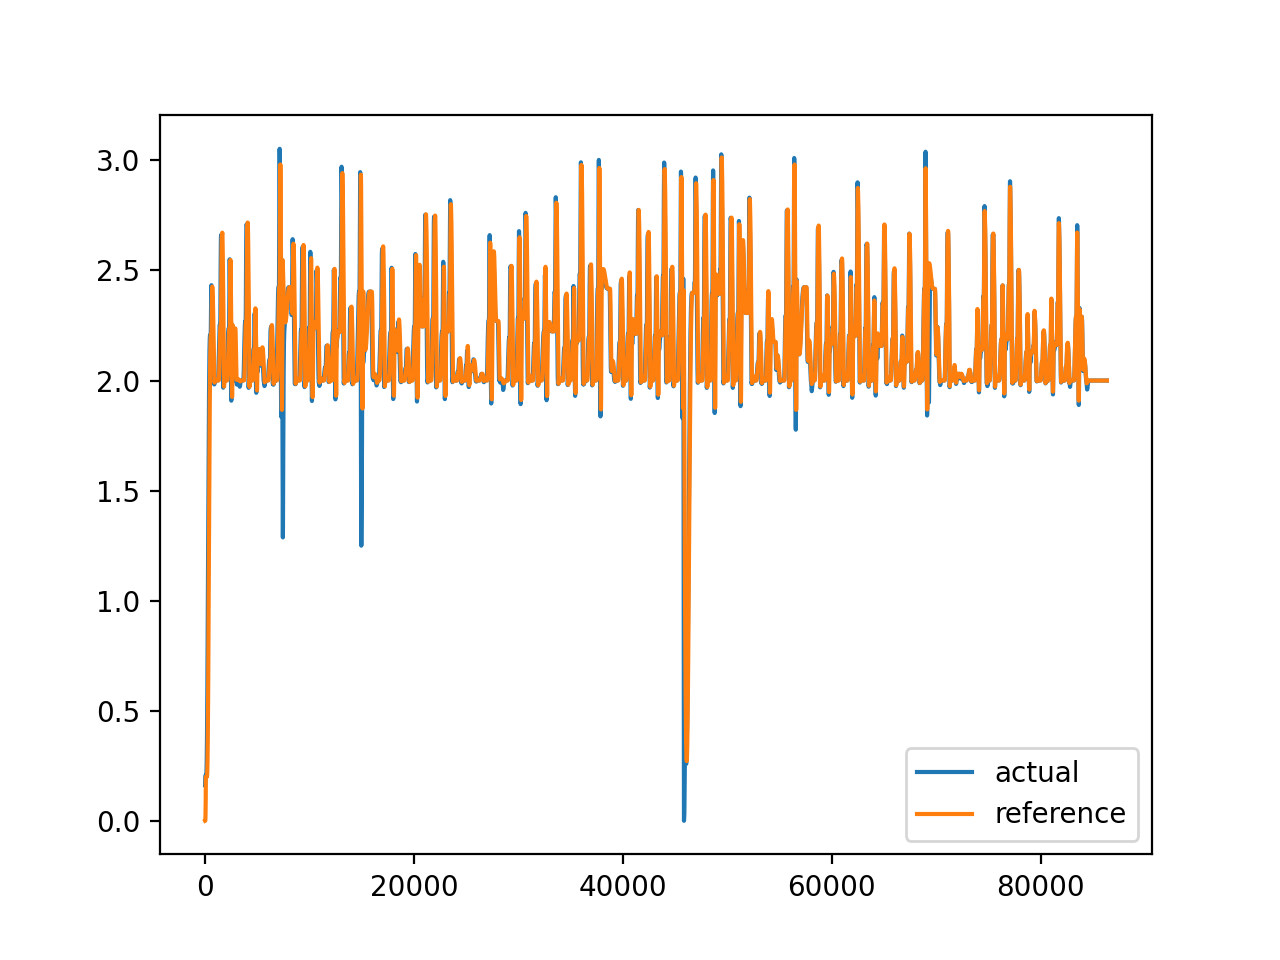

In [144]:
dim = 2
plt.plot(np.arange(actual_traj.shape[0]),actual_traj[:, dim], label='actual')
plt.plot(np.arange(ref_traj.shape[0]),ref_traj[:, dim], label='reference')
plt.legend()

In [51]:
xcost = np.linalg.norm(actual_traj[:,(0,1,2)] - ref_traj[:,(0,1,2)], axis=1)**2 
ucost = 0.1 * np.linalg.norm(input_traj, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj[:, 12] - ref_traj[:, 12])
ra = np.abs(actual_traj[:, 12] + 2*np.pi-ref_traj[:,12])
yawcost = np.minimum(ar, ra) ** 2
cost = xcost + yawcost + ucost

3999


<IPython.core.display.Javascript object>


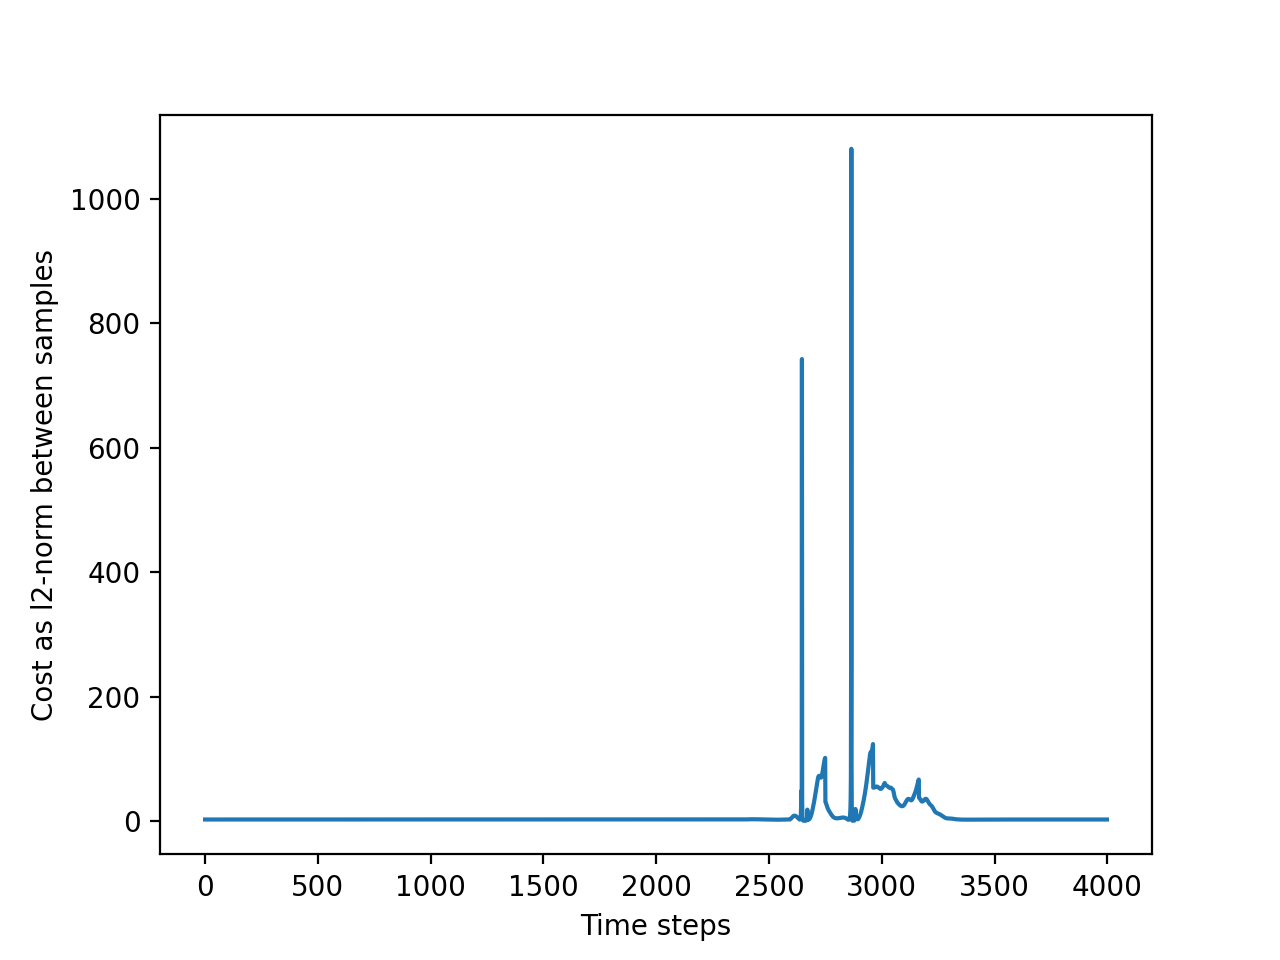

Text(0, 0.5, 'Cost as l2-norm between samples')

In [52]:
Tstart = 0
Tend = cost.shape[0]
print(Tend)
plt.figure()
plt.plot(range(Tstart, Tend), cost.ravel()[Tstart:Tend])
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")


10450


<IPython.core.display.Javascript object>


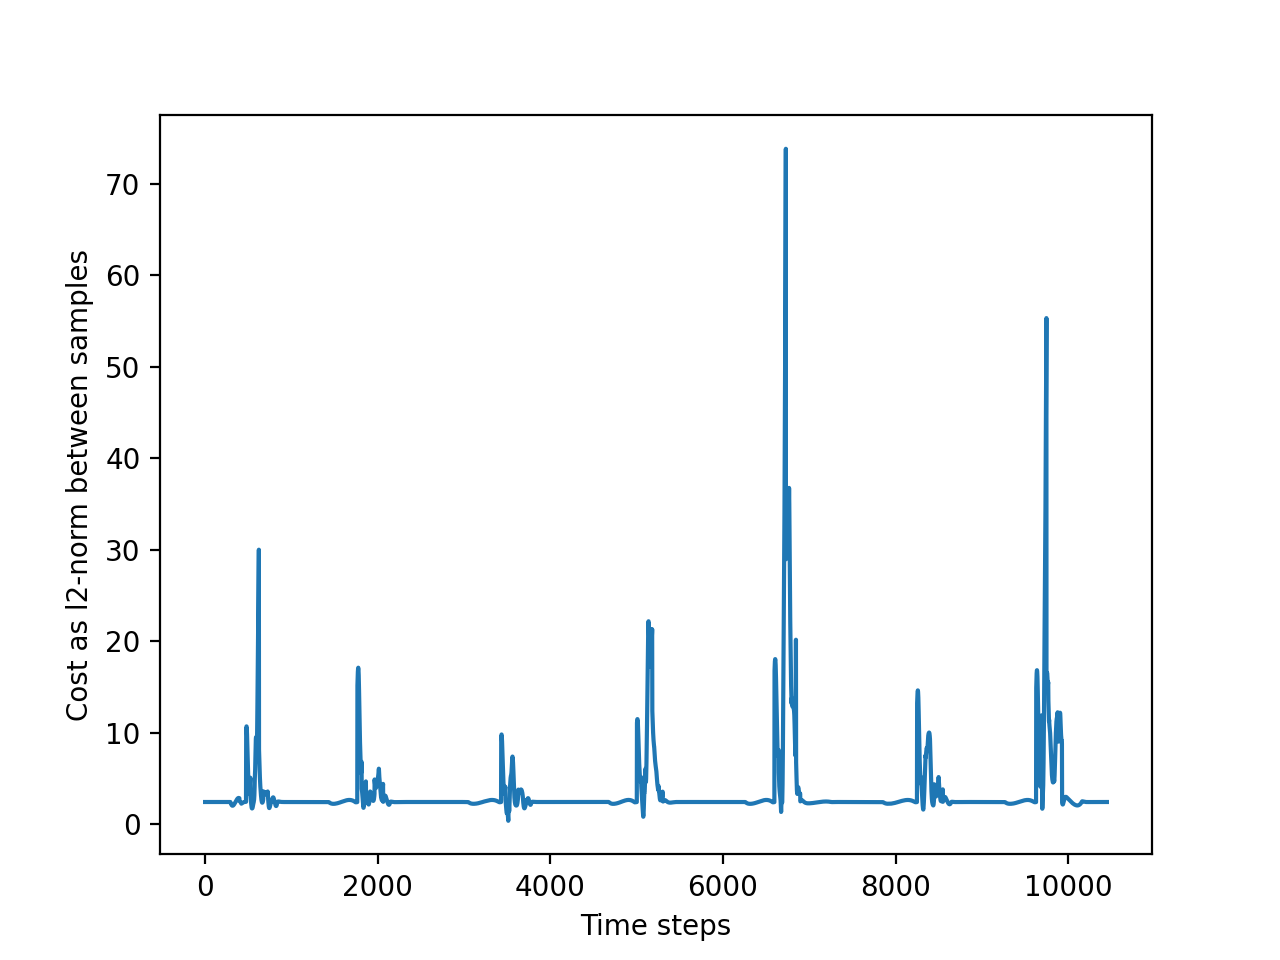

2.4059027058219975


In [102]:
Tstart = 0
Tend = 10450
print(Tend)
plt.figure()
plt.plot(range(Tstart, Tend), c.ravel()[Tstart:Tend])
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")
print(cost[6500])

In [95]:
ref_traj1.append(ref_traj[Tstart:Tend])
actual_traj1.append(actual_traj[Tstart:Tend])
input_traj1.append(input_traj[Tstart:Tend])

# print(ref_traj[Tstart:Tend].shape)
# print(ref_traj1.shape)
print(Tstart)
print(Tend)

28000
29500


In [100]:
temp1 = np.array(np.vstack(ref_traj1))
print(temp1.shape)

temp2 = np.array(np.vstack(actual_traj1))
print(temp2.shape)

temp3 = np.array(np.vstack(input_traj1))
print(temp3.shape)


xc = np.linalg.norm(temp2[:,(0,1,2)] - temp1[:,(0,1,2)], axis=1)**2 
uc = 0.1 * np.linalg.norm(temp3, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(temp2[:, 12] - temp1[:, 12])
ra = np.abs(temp2[:, 12] + 2*np.pi-temp1[:,12])
yawc = np.minimum(ar, ra) ** 2
c = xc + yawc + uc

(10450, 14)
(10450, 14)
(10450, 4)


In [77]:
ref_traj1 = []
actual_traj1 = []
input_traj1 = []
cost_traj1 = []

ref_traj1.append(ref_traj[Tstart:Tend])
actual_traj1.append(actual_traj[Tstart:Tend])
input_traj1.append(input_traj[Tstart:Tend])
# print(input_traj1.shape)
cost_traj1.append(cost_traj[Tstart:Tend])
# print(cost_traj1.shape)

In [75]:
ref_traj1 = np.array(ref_traj[Tstart:Tend])
actual_traj1 = np.array(actual_traj[Tstart:Tend])
input_traj1 = np.array(input_traj[Tstart:Tend])
print(input_traj1.shape)
cost_traj1 = np.array(cost_traj[Tstart:Tend])
print(cost_traj1.shape)

(1100, 4)
(1100,)


In [29]:
np.delete(ref_traj1)

SyntaxError: invalid syntax (4285159393.py, line 1)

<IPython.core.display.Javascript object>


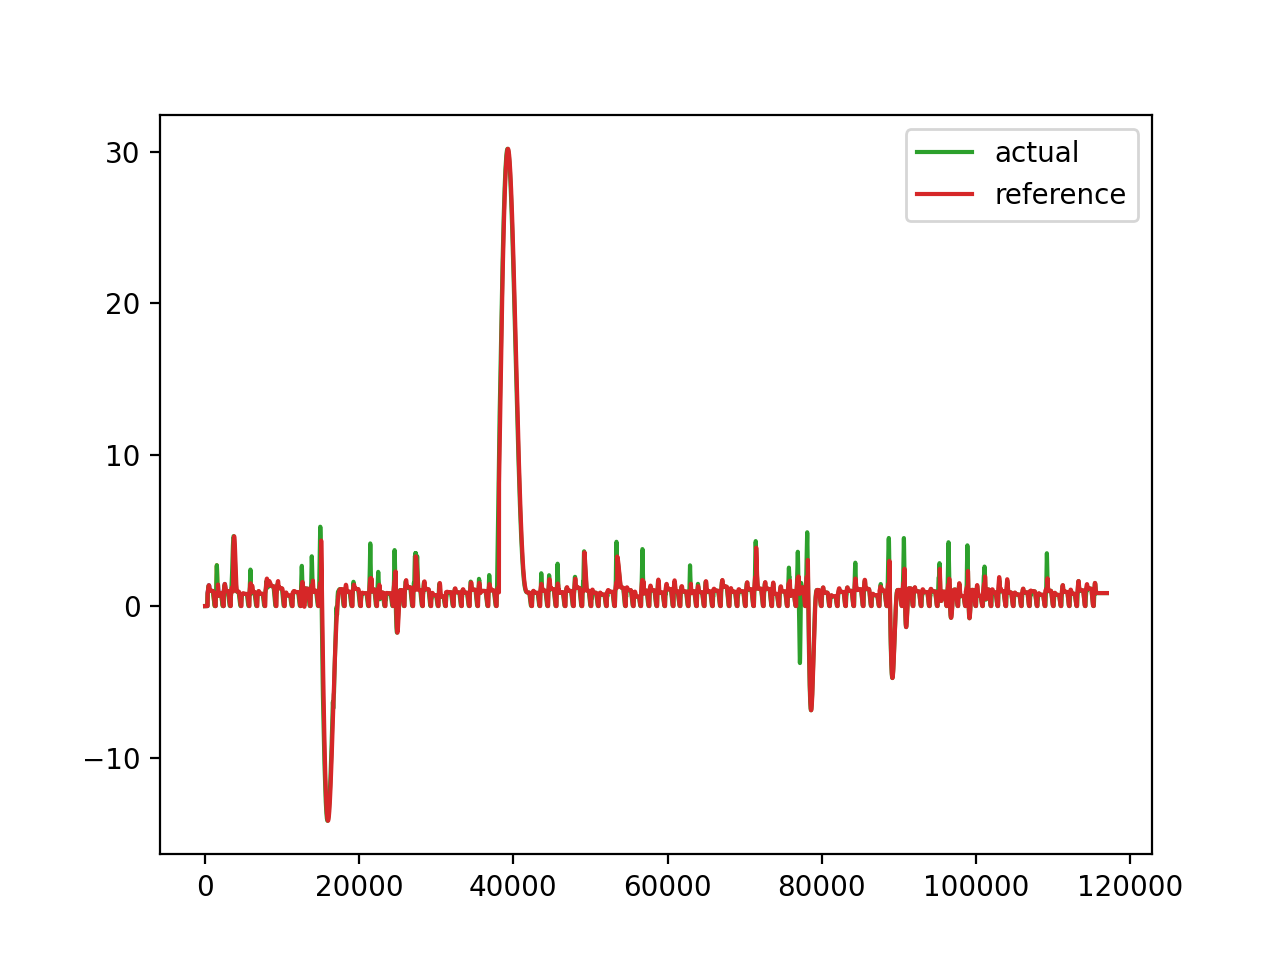

In [137]:
plt.plot(range(Tstart, 3000), ref_traj[:3000, 0], actual_traj[:3000, 0])

In [40]:
%matplotlib notebook

0
70388


<IPython.core.display.Javascript object>


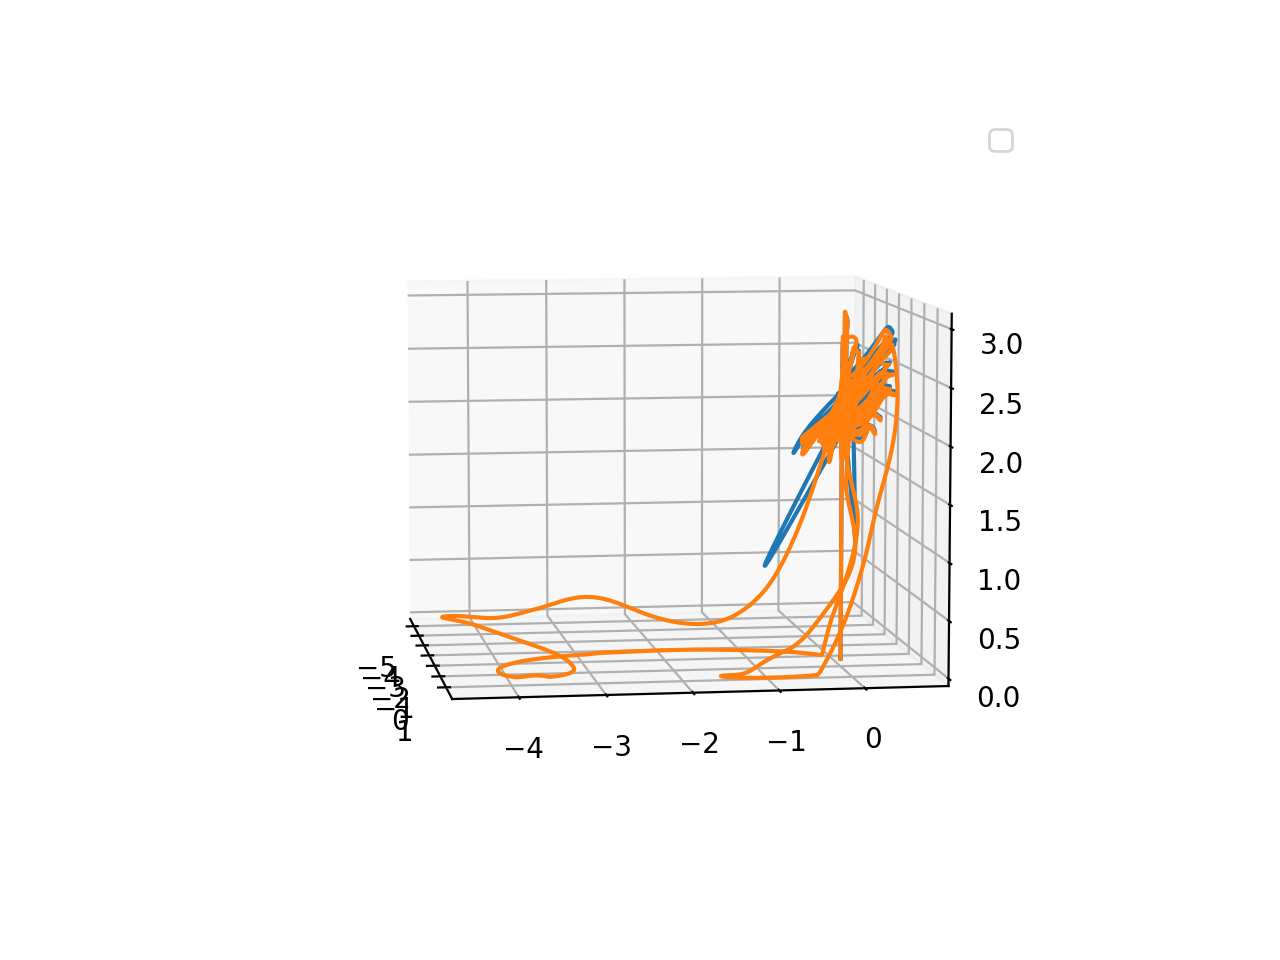

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [91]:
# Visualize bag data
from mpl_toolkits.mplot3d import Axes3D

Tstart = 0
Tend = ref_traj.shape[0]
print(Tstart)
print(Tend)
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
# ttraj = actual_traj.copy()
# axes = plt.gca(projection='3d')
axes.plot3D(ref_traj[Tstart:Tend, 0], ref_traj[Tstart:Tend, 1], ref_traj[Tstart:Tend, 2])
axes.plot3D(actual_traj[Tstart:Tend, 0], actual_traj[Tstart:Tend, 1], actual_traj[Tstart:Tend, 2])
# axes = plt.gca(projection='3d')
#axes.plot3D(ref_traj_nn[Tstart:Tend, 0], ref_traj_nn[Tstart:Tend, 1], ref_traj_nn[Tstart:Tend, 2])
#axes.plot3D(actual_traj_nn[Tstart:Tend, 0], actual_traj_nn[Tstart:Tend, 1], actual_traj_nn[Tstart:Tend, 2])
axes.legend()

## Define augmented states for network

In [37]:
# Construct augmented states
time_steps = 300
gamma = 0.99

idx = [0, 1, 2, 12]

cost_traj1 = cost_traj1.ravel()

ref_chunks = np.array([ref_traj1[x:x + time_steps] for x in range(0, len(ref_traj1)-time_steps)])
print(ref_chunks.shape)
aug_state = []
for xa, rref in zip(actual_traj1[:-time_steps], ref_chunks):
    aug_state.append(np.concatenate([xa[idx], rref[:, idx].flatten()]))
aug_state = np.array(aug_state)
print(aug_state.shape)

(14505, 300, 14)
(14505, 1204)


## Train network

In [38]:
dataset = trajdata.TrajDataset(aug_state[:-1], input_traj1[:-1],
                               cost_traj1[:-1-time_steps, None], aug_state)
dataset.cuda()

In [1]:
p = aug_state.shape[1]
q = 4

icnnvalue = valuefunc.ICNNValueFunc(p, [400, 400, 1])
icnnvalue.network = icnnvalue.network.cuda()
icnnvalue.learn(dataset, gamma, num_epoch=1000, batch_size=64, verbose=True, print_interval=50, lr=0.005)

NameError: name 'aug_state' is not defined

In [39]:
p = aug_state.shape[1]
q = 4

mlpvalue = valuefunc.MLPValueFunc(p, [300, 300, 1])
mlpvalue.network = mlpvalue.network.cuda()
mlpvalue.learn(dataset, gamma, num_epoch=1000, batch_size=64, verbose=True, print_interval=50, lr=0.0005)

Epoch: 1 	 Training loss: 3.398830220949188
Epoch: 51 	 Training loss: 0.14827050217370438
Epoch: 101 	 Training loss: 0.00498437024996201


KeyboardInterrupt: 

## Save network model

In [18]:
torch.save(icnnvalue, '/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/trained_models/lissajous_model.pt')

In [48]:
torch.save(mlpvalue, '/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/trained_models/lissajous_mlp_model.pt')

## Load network model

In [8]:
icnnvalue = torch.load('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/trained_models/lissajous_model.pt')

In [41]:
mlpvalue.network.cpu()
icnnvalue.network.cpu()

ICNN(
  (activate): ELU(alpha=1.0)
)

In [71]:
vf = torch.load('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/trained_models/mlp1_new.pt')

In [84]:
vf.network(torch.randn(1, 4214).double())

tensor([[42.9309]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [83]:
vf = valuefunc.MLPValueFunc(4214, [100, 100, 1])
vf.network.load_state_dict(torch.load('/home/anusha/Downloads/mlpsd'))

<All keys matched successfully>

# Test if the network is learning the right cost

In [33]:
# Cost computed using the discount factor 0.99
time_steps = 300
alpha = 0.99
cost_manual = list()
cost_pred = list()
alpha_vec = list()

idx = [0, 1, 2, -2]
actual_chunks = np.array([actual_traj1[x:x + time_steps] for x in range(0, len(actual_traj1)-time_steps)])
input_chunks = np.array([input_traj1[x:x + time_steps] for x in range(0, len(input_traj1)-time_steps)]) 

for i in range(0, 300):
    alpha_vec.append(alpha ** i)

for xa, act, ref, inp in zip(actual_traj1[0:500], actual_chunks[0:500], ref_chunks[0:500], input_chunks[0:500]):
    # sum = 0
    # for i in range(0, time_steps):
    #    sum = sum + alpha * ref[i]
    print(np.dot(np.array(alpha_vec), np.linalg.norm(act[:, idx] - ref[:, idx], axis=1) ** 2 + 
                 0.01 * np.linalg.norm(inp, axis=1) ** 2))
    cost_manual.append(np.dot(np.array(alpha_vec), np.linalg.norm(act[:, idx] - ref[:, idx], axis=1)))
    cost_pred.append(icnnvalue.network(torch.tensor(np.concatenate([xa[idx], rref[:, idx].flatten()]))).detach().numpy())

23.225567972041752
23.212565286253046
23.19978796243333
23.187214685042683
23.1748192800746
23.162585407613825
23.150632692474993
23.13887986563281
23.127408686941028
23.116154269283967
23.105212163015256
23.094557324425637
23.0841794688614
23.074040626951312
23.064257063787743
23.054740253635163
23.045581360865175
23.03675408177158
23.028236789709354
23.020043890340467
23.01217824807926
23.00463934881294
22.997428068985702
22.990544008023114
22.983987312265633
22.977705435506568
22.971793379994224
22.966162296290804
22.960882361295212
22.955875675115227
22.951208532680145
22.946806986333346
22.942733494734565
22.938915467513542
22.93540765462661
22.93218044385612
22.929210004330844
22.926468477925233
22.924007232754466
22.921762482366486
22.919748940517316
22.917965014265416
22.916421948222727
22.915066126384644
22.913935321974254
22.912979350072913
22.912225354528235
22.911648643826812
22.91124195906019
22.910995870220017
22.91089861041308
22.910947389925457
22.91113694808491
22.9114

In [46]:
%matplotlib inline

(4700, 300, 14)
500
[248.67404462 248.66389724 248.65408848 248.64133769 248.62910025
 248.61633482 248.6044681  248.58957172 248.57713613 248.56173679
 248.54904287 248.5334949  248.51939428 248.50538333 248.49289069
 248.47782405 248.46568978 248.4511216  248.4381489  248.42545044
 248.4130368  248.40091378 248.3890839  248.37754742 248.36630339
 248.3553501  248.34573938 248.33431087 248.32522114 248.31443199
 248.30586886 248.29572894 248.28770209 248.27822389 248.27074257
 248.26193313 248.25424358 248.24685672 248.24046453 248.23297545
 248.22710824 248.22085737 248.21488072 248.20861194 248.20371269
 248.19799424 248.19352818 248.18831937 248.18381252 248.17951304
 248.17541136 248.17149826 248.16776406 248.16419904 248.16079352
 248.15753763 248.15442169 248.1514364  248.14857263 248.14582132
 248.14317383 248.14062188 248.13815746 248.13577309 248.1334618
 248.1312171  248.12903303 248.12690418 248.12482565 248.12279307
 248.12080258 248.11885079 248.11693476 248.11505194 248.

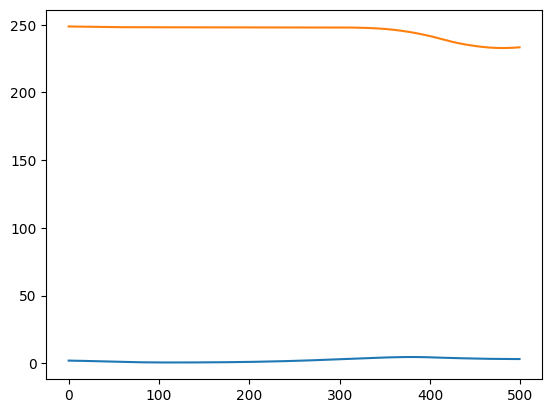

In [32]:
print(ref_chunks.shape)
print(len(cost_manual))
print(np.array(cost_pred).ravel())
plt.plot(range(0, 500), np.array(cost_manual).ravel(), np.array(cost_pred).ravel())

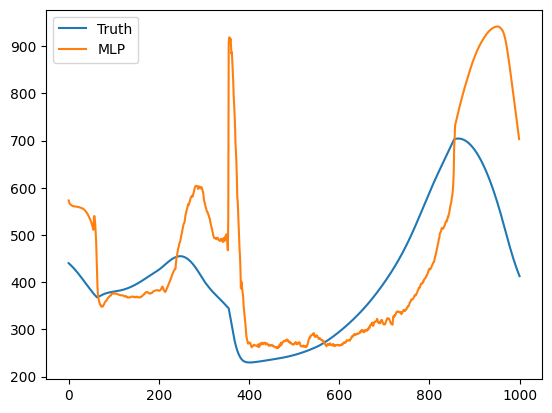

In [49]:
def moving_sum(x, window_size, gamma=1):
    conv = np.convolve(x, gamma ** np.arange(window_size-1, -1, -1))
    return conv[window_size-1:-window_size+1]

# Test whether NNs memorized the training data
Tref = 300
Tstart = 0
Tend = 1000
gamma = 0.99
test_x = aug_state[0:1000]
test_cost = cost_traj1[Tstart:Tend+Tref]
# Compute the true values
true_values = moving_sum(test_cost, Tref, gamma)
plt.plot(range(0, 1001), true_values, label='Truth')
# Compute the cost from NN
#icnn_values = icnnvalue.network(torch.tensor(xtraj[Tstart:Tend]))[:,0].detach()
#plt.plot(icnn_values, label='ICNN')
# icnn_values = icnnvalue.network(torch.tensor(aug_state[Tstart:Tend]))[:,0].detach()
# plt.plot(icnn_values, label='ICNN')
mlp_values = mlpvalue.network(torch.tensor(aug_state[Tstart:Tend]))[:,0].detach()
plt.plot(mlp_values, label='MLP')
plt.legend()

## Evaluate network

In [50]:
# Inference on a Lissajous curve
import random

PI = np.pi 

def generate_lissajous_traj(s, x_num_periods, y_num_periods, z_num_periods, yaw_num_periods, period, x_amp, y_amp, z_amp, yaw_amp):
    """
    Function to generate Lissajous trajectory
    :return:
    """
    x = lambda a: x_amp * (1 - np.cos(2 * PI * x_num_periods * a / period))
    y = lambda a: y_amp * np.sin(2 * PI * y_num_periods * a / period)
    z = lambda a: z_amp * np.sin(2 * PI * z_num_periods * a / period)
    yaw = lambda a: yaw_amp * np.sin(2 * PI * yaw_num_periods * a / period)
    return [x(s), y(s), z(s), yaw(s)]


x_amp = 1.25 * random.random()
y_amp = 1.25 * random.random()
z_amp = 0.75 * random.random()
yaw_amp = 3.1414 * random.random()
x_num_periods = 1
y_num_periods = 1
z_num_periods = 1
yaw_num_periods = 1
period = 3
num_cycles = 1
ramp_time = 2

ref = generate_lissajous_traj(np.linspace(0, 3, 301), x_num_periods, y_num_periods, z_num_periods, yaw_num_periods, period, x_amp,
                             y_amp, z_amp, yaw_amp)

In [51]:
waypt = np.array(ref)[:, 0::100]
print(waypt.shape)

(4, 4)


# Generate waypoints on Lissajous and initial guess of coeff

In [52]:
p = 4

segments = 6
ts = np.linspace(0, 3, segments + 1)
order = 5
Tref = 300
waypt = np.array(ref)[:, 0::50]
print("Waypt shape", waypt.shape)
_, minjerk_coeffs = quadratic.generate(waypt.T, ts, order, Tref, p, None, 0)

Waypt shape (4, 7)


In [24]:
segments = 3
ts = np.linspace(0, 3, segments+1) 
order = 5
Tref = 300
_, minjerk_coeffs = quadratic.generate(waypt.T, ts, order, Tref, p, None, 0)

IndexError: index 4 is out of bounds for axis 0 with size 4

In [9]:
icnnvalue.network = icnnvalue.network.cpu()

# Compute nn coeff

In [56]:
# Generate regularized trajectory from gradient descent on NN
rho = 0.1
nn_coeff = nonlinear.generate(torch.tensor(waypt), ts, order, Tref, p, rho, mlpvalue, torch.tensor(minjerk_coeffs),
                   num_iter=100, lr=0.01)

# Plot 2D and 3D trajectories

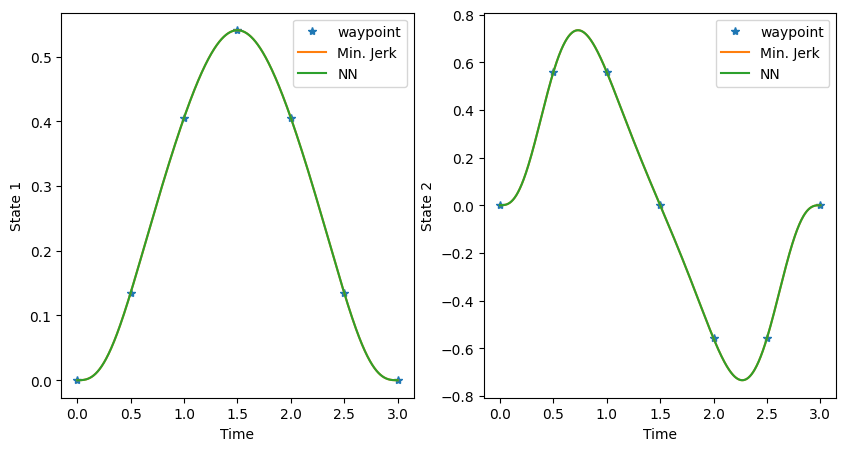

In [57]:
# Plot the trajectories
t, origx = nonlinear.coeff2traj(minjerk_coeffs, ts, 1000)
t, nnx = nonlinear.coeff2traj(nn_coeff, ts, 1000)
# t, solx, = nonlinear.coeff2traj(sol_coeffs, ts, 1000)
plt.figure(figsize=(10, 5))
# Dimension 0
plt.subplot(1,2,1)
plt.plot(ts, waypt[0, :], '*', label='waypoint')
plt.plot(t, origx[0], label='Min. Jerk')
plt.plot(t, nnx[0], label='NN')
#plt.plot(t, solx[0], label='Closed-form')
plt.xlabel('Time')
plt.ylabel('State 1')
plt.legend()

# Dimension 1
plt.subplot(1,2,2)
plt.plot(ts, waypt[1, :], '*', label='waypoint')
plt.plot(t, origx[1], label='Min. Jerk')
plt.plot(t, nnx[1], label='NN')
#plt.plot(t, solx[1], label='Closed-form')
plt.xlabel('Time')
plt.ylabel('State 2')
plt.legend()

In [60]:
%matplotlib notebook

<IPython.core.display.Javascript object>


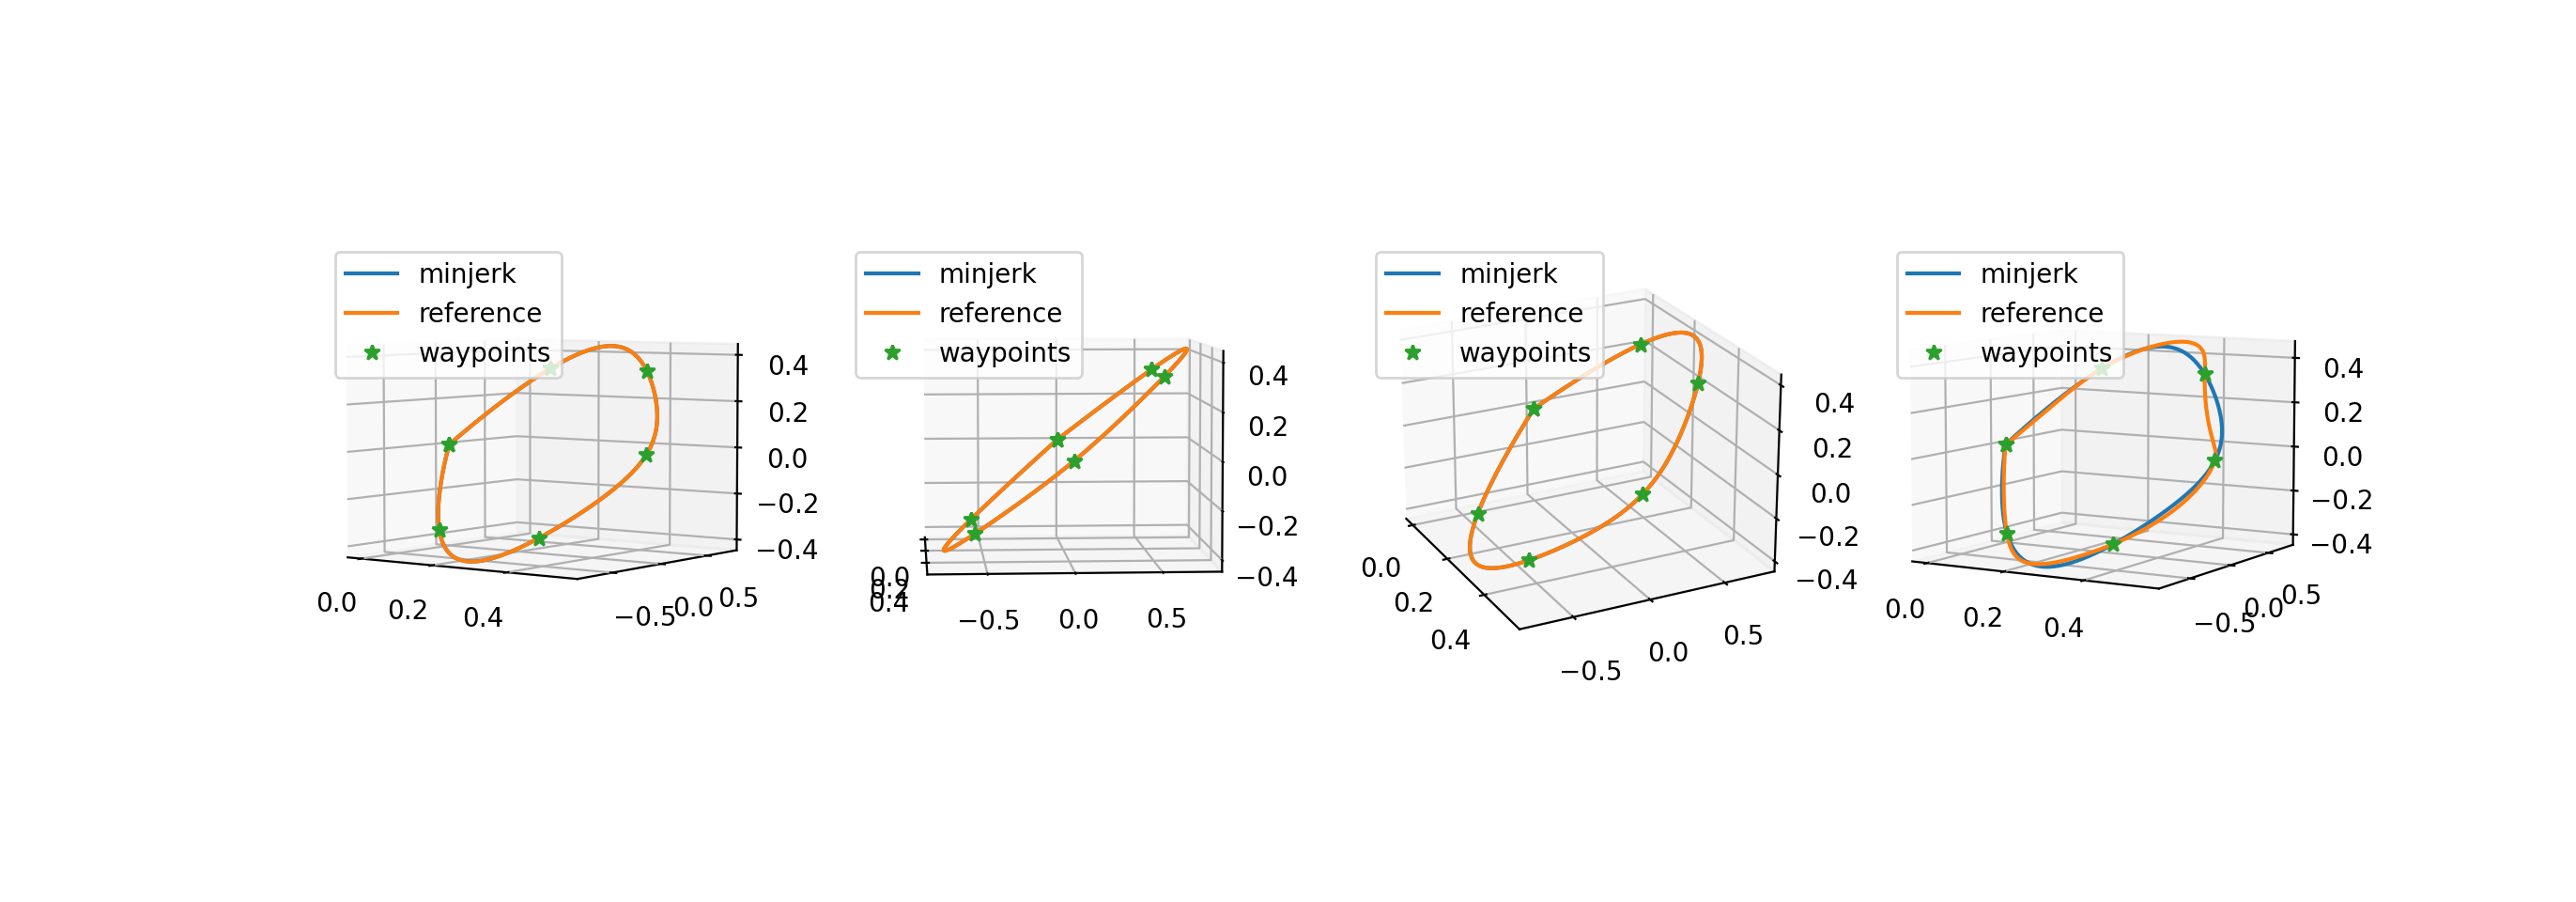

4


In [61]:
rhos = np.concatenate([[0], np.logspace(-3, 2, 3)])
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.35))

# =============
# First subplot
# =============
print(len(rhos))

for i, rho in enumerate(rhos):
    nn_coeff = nonlinear.generate(torch.tensor(waypt), ts, order, Tref, p, rho, mlpvalue, torch.tensor(minjerk_coeffs),
                   num_iter=100, lr=0.01)
    t, origx = nonlinear.coeff2traj(minjerk_coeffs, ts, 1000)
    t, nnx = nonlinear.coeff2traj(nn_coeff, ts, 1000)
    # t, solx, = nonlinear.coeff2traj(sol_coeffs, ts, 1000)
    # set up the axes for the first plot
    ax = fig.add_subplot(1, len(rhos), i+1, projection='3d')
    # ax = plt.gca(projection='3d')
    # plt.subplot(1, len(rhos), i+1)
    ax.plot3D(origx[0], origx[1], origx[2], label='minjerk')
    ax.plot3D(nnx[0], nnx[1], nnx[2], label='reference')
    ax.plot3D(waypt[0, :], waypt[1, :], waypt[2, :], '*', label='waypoints')
    # ax.set_xlim(0, 0.8)
    # ax.set_ylim(0, 1)
    # ax.set_zlim(0, 0.4)
    ax.legend()

## Visualization for the paper

In [45]:
test_cost

array([25.62940174, 25.59278573, 25.5589559 , ..., 20.68045324,
       20.64993529, 20.61914919])

In [ ]:
# End of experiment

In [5]:
# Load bag with waypt traj
bag2 = load_bag('/home/anusha/Research/ws_kr/src/wp_traj.bag')
ref_traj2, actual_traj2, input_traj2, cost_traj2 = compute_traj(bag2)
bag2.close()

In [64]:
print(np.array(cost_traj).shape)

(1, 178288)


In [68]:
print(cost_traj[0][90:100])

[30.2512137  29.71679795 28.8738554  27.78666674 26.51400561 25.10786161
 23.61407753 22.07163858 20.51349249 18.96682151]


In [69]:
ref_traj = np.array(ref_traj[0:70600])
actual_traj = np.array(actual_traj[0:70600])
input_traj = np.array(input_traj[0:70600])
# cost_traj = np.array(cost_traj[0][0:70600])

np.savetxt('ref_lissajous14dim', ref_traj[13000:23000])
np.savetxt('actual_lissajous14dim', actual_traj[13000:23000])
np.savetxt('input_lissajous14dim', input_traj[13000:23000])
np.savetxt('cost_lissajous14dim', cost_traj[0][13000:23000])

In [51]:
## Check if vel, acc, jerk all make sense

pos = actual_traj[13000:23000, 0:3]
vel = actual_traj[13000:23000, 3:6]
acc = actual_traj[13000:23000, 6:9]
jerk = actual_traj[13000:23000, 9:12]

print(acc[10] * 0.01+ vel[10])

print(vel[11])

[-0.07650411  0.36343905  0.34563232]
[-0.07646978  0.36310736  0.34531714]


ValueError: operands could not be broadcast together with shapes (10000,3) (100,) 

In [56]:
ref_traj2 = np.array(ref_traj2)
actual_traj2 = np.array(actual_traj2)
input_traj2 = np.array(input_traj2)
cost_traj2 = np.array(cost_traj2)

np.savetxt('ref_traj_waypt', ref_traj2[0:8000])
np.savetxt('actual_traj_waypt', actual_traj2[0:8000])
np.savetxt('input_traj_waypt', input_traj2[0:8000])
np.savetxt('cost_traj_waypt', cost_traj2[0:8000])

In [7]:
print(ref_traj2.shape)

(107818, 10)


In [6]:
print(cost_traj.shape)

(70600,)


In [1]:
%matplotlib notebook

<IPython.core.display.Javascript object>


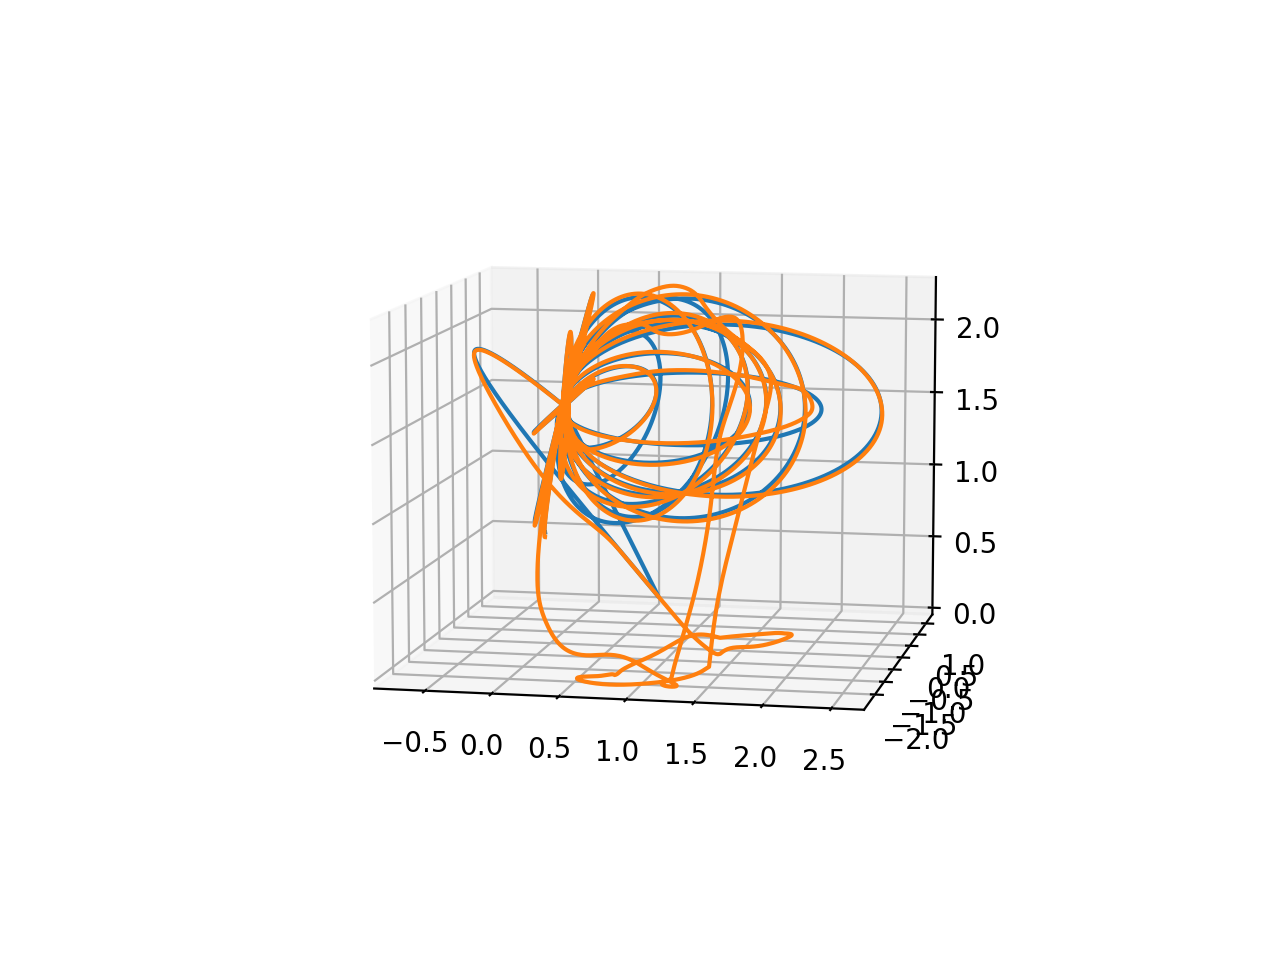

In [6]:
# Visualize loaded bag
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
# ttraj = actual_traj.copy()
# axes = plt.gca(projection='3d')
axes.plot3D(ref_traj[13000:23000, 0], ref_traj[13000:23000,1], ref_traj[13000:23000,2])
axes.plot3D(actual_traj[13000:23000,0], actual_traj[13000:23000,1], actual_traj[13000:23000,2])

In [10]:
# Construct augmented states
time_steps = 100
gamma = 0.99

ref_chunks = np.array([ref_traj[x:x + time_steps] for x in range(0, len(ref_traj)-time_steps)])
aug_state = []
for xa, rref in zip(actual_traj[:-time_steps], ref_chunks):
    aug_state.append(np.concatenate([xa, rref.flatten()]))
aug_state = np.array(aug_state)

In [11]:
# Construct augmented states
time_steps = 100
gamma = 0.99

ref_chunks = np.array([ref_traj2[x:x + time_steps] for x in range(0, len(ref_traj2)-time_steps)])
aug_state2 = []
for xa, rref in zip(actual_traj2[:-time_steps], ref_chunks):
    aug_state2.append(np.concatenate([xa, rref.flatten()]))
aug_state2 = np.array(aug_state)

In [12]:
print(aug_state2.shape)

(70500, 1010)


In [13]:
dataset = trajdata.TrajDataset(aug_state2[0:8000], input_traj2[0:8000],
                               cost_traj2[0:8000, None], aug_state2[1:8001])
dataset.cuda()

In [15]:
# Load model
icnnvalue = torch.load('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/first_decent_model.pt')

In [16]:
# Use the augmented states to do lstd
p = aug_state2.shape[1]
q = 4

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# dataset = trajdata.TrajDataset(aug_state[:-1], input_traj[:-time_steps-1],
#                                cost_traj[:-time_steps-1, None], aug_state[1:])

# dataset = trajdata.TrajDataset(aug_state[0:1000], input_traj[0:1000],
#                               cost_traj[0:1000, None], aug_state[1:1001])


# icnnvalue = valuefunc.ICNNValueFunc(p, [400, 400, 1])
icnnvalue.network = icnnvalue.network.cuda()
icnnvalue.learn(dataset, gamma, num_epoch=1000, batch_size=64, verbose=True, print_interval=50, lr=0.005)

Epoch: 1 	 Training loss: 185637.47097883304
Epoch: 51 	 Training loss: 11.559243901340377
Epoch: 101 	 Training loss: 0.8261539382592592
Epoch: 151 	 Training loss: 0.4963612624824681
Epoch: 201 	 Training loss: 4.543013344974943
Epoch: 251 	 Training loss: 1.8307516876908827
Epoch: 301 	 Training loss: 0.028358629896196353
Epoch: 351 	 Training loss: 0.01980624980365798
Epoch: 401 	 Training loss: 0.3261601455175079
Epoch: 451 	 Training loss: 0.6185693141997557
Epoch: 501 	 Training loss: 4.2131996635296565
Epoch: 551 	 Training loss: 0.408126358519701
Epoch: 601 	 Training loss: 0.08680297711134927
Epoch: 651 	 Training loss: 0.5622612534672716
Epoch: 701 	 Training loss: 0.13880970166101606
Epoch: 751 	 Training loss: 0.33121280583806173
Epoch: 801 	 Training loss: 2.02985097241658
Epoch: 851 	 Training loss: 0.42745095049313775
Epoch: 901 	 Training loss: 0.21528248755181223
Epoch: 951 	 Training loss: 0.1866309763064764


In [17]:
# Save trained model
# torch.save(icnnvalue.state_dict(), './trained_model.pth')
torch.save(icnnvalue, '/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/second_decent_model.pt')

In [16]:
# Load model
icnnvalue = torch.load('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/second_decent_model.pt', map_location=torch.device('cpu'))

In [17]:
icnnvalue.network = icnnvalue.network.cpu()

In [43]:
# Inference on a Lissajous curve
import random

PI = np.pi 

def generate_lissajous_traj(s, x_num_periods, y_num_periods, z_num_periods, yaw_num_periods, period, x_amp, y_amp, z_amp, yaw_amp,
                  ramp_time, num_cycles):
    """
    Function to generate Lissajous trajectory
    :return:
    """
    x = lambda a: x_amp * (1 - np.cos(2 * PI * x_num_periods * a / period))
    y = lambda a: y_amp * np.sin(2 * PI * y_num_periods * a / period)
    z = lambda a: z_amp * np.sin(2 * PI * z_num_periods * a / period)
    yaw = lambda a: yaw_amp * np.sin(2 * PI * yaw_num_periods * a / period)
    return [x(s), y(s), z(s), yaw(s)]


x_amp = 1.25 * random.random()
y_amp = 1.25 * random.random()
z_amp = 0.75 * random.random()
yaw_amp = 3.1414 * random.random()
x_num_periods = 1
y_num_periods = 1
z_num_periods = 1
yaw_num_periods = 1
period = 3
num_cycles = 1
ramp_time = 2

ref = generate_lissajous_traj(np.linspace(0, 1, 4)*2, x_num_periods, y_num_periods, z_num_periods, yaw_num_periods, period, x_amp,
                             y_amp, z_amp, yaw_amp, ramp_time, num_cycles)

In [44]:
print(np.array(ref).shape)

(4, 4)


In [45]:
idx = range(4, 10)
waypt = np.zeros([4, 10])
waypt[:, idx] = 0
waypt[:, 0:4] = np.array(ref)
print(waypt)

[[ 0.          0.66036665  1.55007623  1.19870247  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.64586302  0.22430587 -0.5679624   0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.17243293  0.05988533 -0.15163498  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.40585973  0.1409536  -0.35690705  0.          0.
   0.          0.          0.          0.        ]]


In [34]:
# Generate a waypoints and the min-jerk trajectory
sample = list()
segments = 3
goals = np.random.random([3, 2]) * 1.2 + 0.5
points = np.linspace(0, 1, segments+1)
for i in range(segments+1):
    sample.append(goals[:, 0] + (goals[:, 1] - goals[:, 0]) * points[i])
idx = range(3, 10)
waypt = np.zeros([segments+1, 10])
waypt[:, idx] = None
waypt[:, 0:segments] = np.vstack(sample)

In [46]:
print(waypt)

[[ 0.          0.66036665  1.55007623  1.19870247  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.64586302  0.22430587 -0.5679624   0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.17243293  0.05988533 -0.15163498  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.40585973  0.1409536  -0.35690705  0.          0.
   0.          0.          0.          0.        ]]


In [47]:
segments = 3
ts = np.linspace(0,1,segments+1) 
print(ts)
order = 6
Tref = 100
_, minjerk_coeffs = quadratic.generate(waypt, ts, order, Tref, 3, None, 0)

[0.         0.33333333 0.66666667 1.        ]


In [48]:
print(minjerk_coeffs)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[-1.96172554e-05  1.00268977e+02 -9.98773661e+01  2.17598608e+01
   -6.82667503e-11 -9.72256639e-10  6.60366644e-01]
  [ 1.57659564e-05 -8.06850991e+01  6.72375747e+01 -6.87404610e-07
   -4.68162316e+00 -1.35391734e+00  6.45863020e-01]
  [-9.87758374e-06  1.10310150e+02 -6.72375730e+01  5.13107552e-07
    3.96943895e+00  5.05560855e-01  1.72432927e-01]]

 [[ 5.07475420e-05 -2.41540472e+02  2.77336238e+02 -1.01403385e+02
    1.35850409e-10  1.93467707e-09  1.55007624e+00]
  [-2.90318638e-05  1.50277406e+02 -1.25231157e+02  1.26475886e-06
    2.97415063e+01 -7.62418251e+00  2.24305865e-01]
  [ 1.86693533e-05 -1.84563475e+02  1.252311

In [49]:
# Use minjerk_coeffs to compute full state traj coeffs

print(waypt.shape)
print(minjerk_coeffs.shape)
coeffs = np.zeros([10, segments, order+1])
# print(coeffs)
idx = range(3, 10)
coeffs[0:3, :, :] = minjerk_coeffs
coeffs[3:, :, :] = 0
print(coeffs.shape)

(4, 10)
(3, 3, 7)
(10, 3, 7)


In [50]:
# Generate regularized trajectory from gradient descent on NN
rho = 0
nn_coeff = nonlinear.generate(torch.tensor(waypt.T), ts, order, Tref, 10, rho, icnnvalue, torch.tensor(coeffs),
                   num_iter=100, lr=0.01)

In [51]:
print(nn_coeff.shape)
print(np.vstack(nn_coeff[0, :, :]).shape)

torch.Size([10, 3, 7])
(3, 7)


<IPython.core.display.Javascript object>


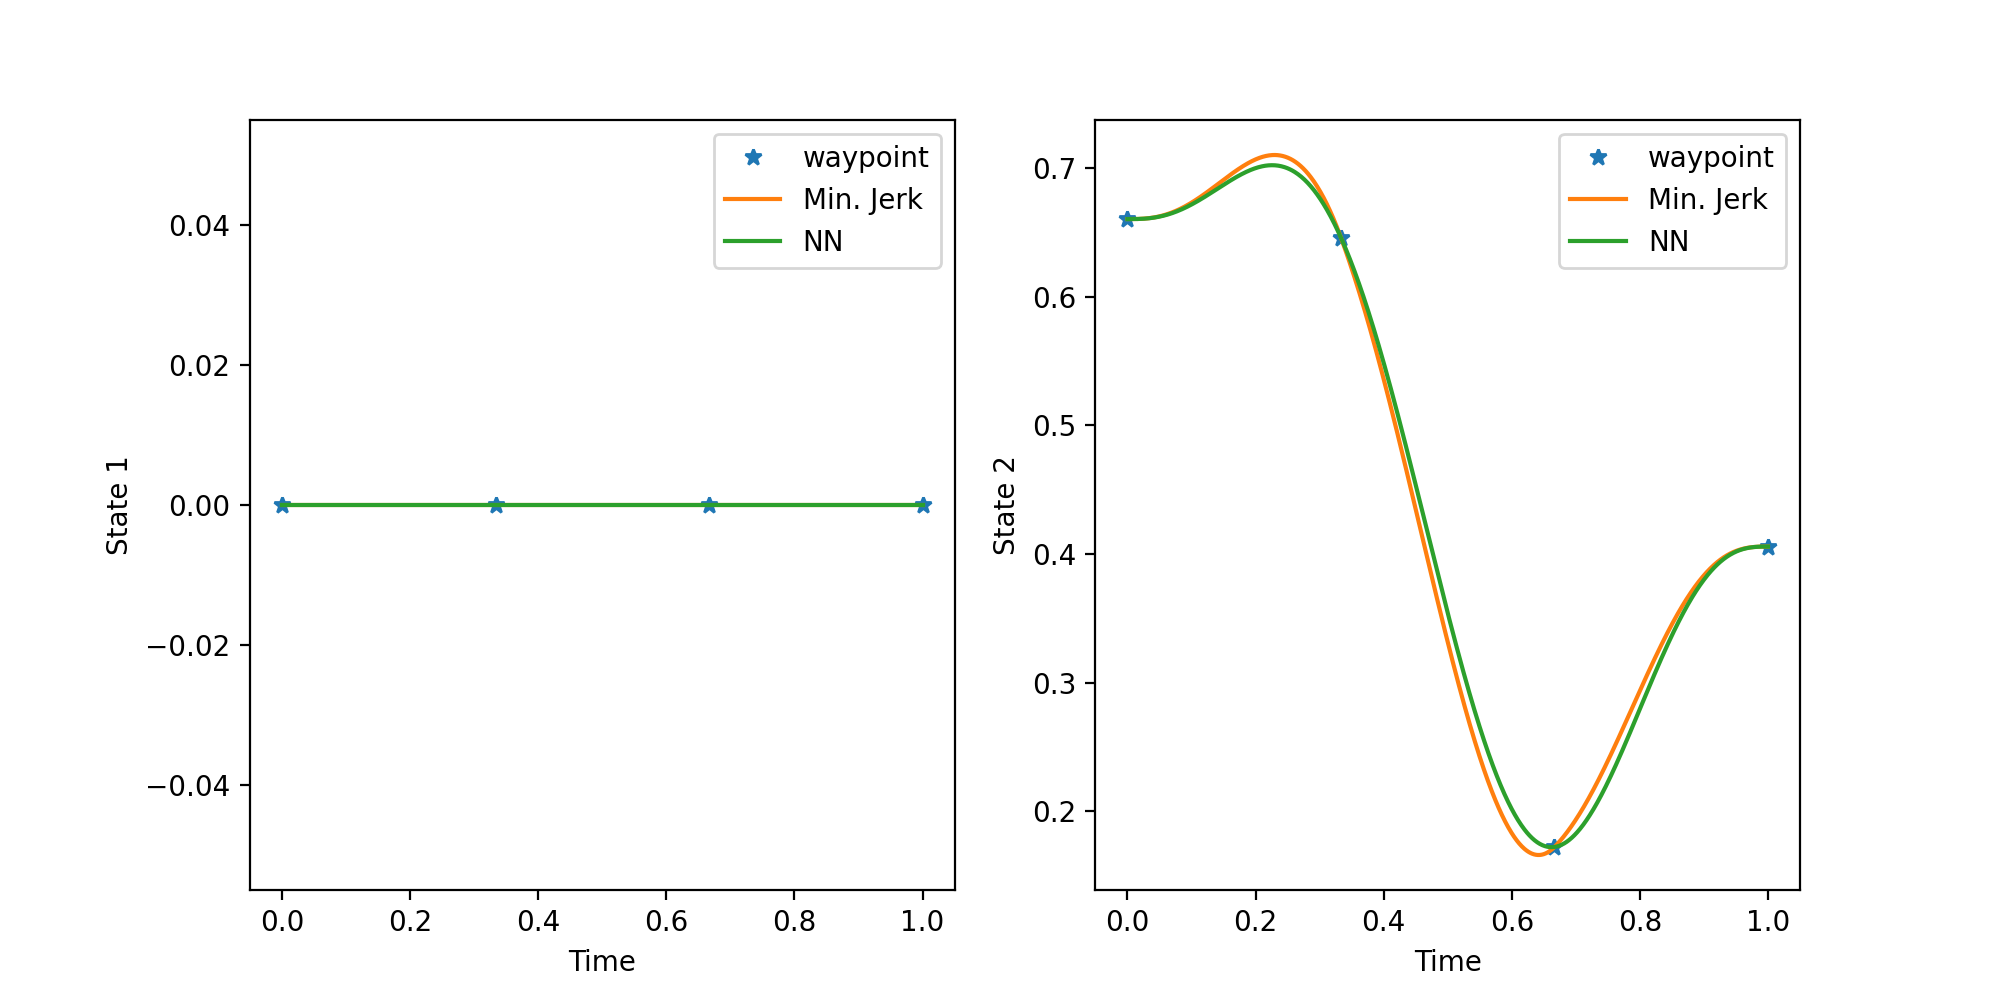

In [52]:
# Plot the trajectories
t, origx = nonlinear.coeff2traj(coeffs, ts, 1000)
t, nnx = nonlinear.coeff2traj(nn_coeff, ts, 1000)
# t, solx, = nonlinear.coeff2traj(sol_coeffs, ts, 1000)
plt.figure(figsize=(10, 5))
# Dimension 0
plt.subplot(1,2,1)
plt.plot(ts, waypt[:, 0], '*', label='waypoint')
plt.plot(t, origx[0], label='Min. Jerk')
plt.plot(t, nnx[0], label='NN')
#plt.plot(t, solx[0], label='Closed-form')
plt.xlabel('Time')
plt.ylabel('State 1')
plt.legend()

# Dimension 1
plt.subplot(1,2,2)
plt.plot(ts, waypt[:, 1], '*', label='waypoint')
plt.plot(t, origx[1], label='Min. Jerk')
plt.plot(t, nnx[1], label='NN')
#plt.plot(t, solx[1], label='Closed-form')
plt.xlabel('Time')
plt.ylabel('State 2')
plt.legend()

<IPython.core.display.Javascript object>


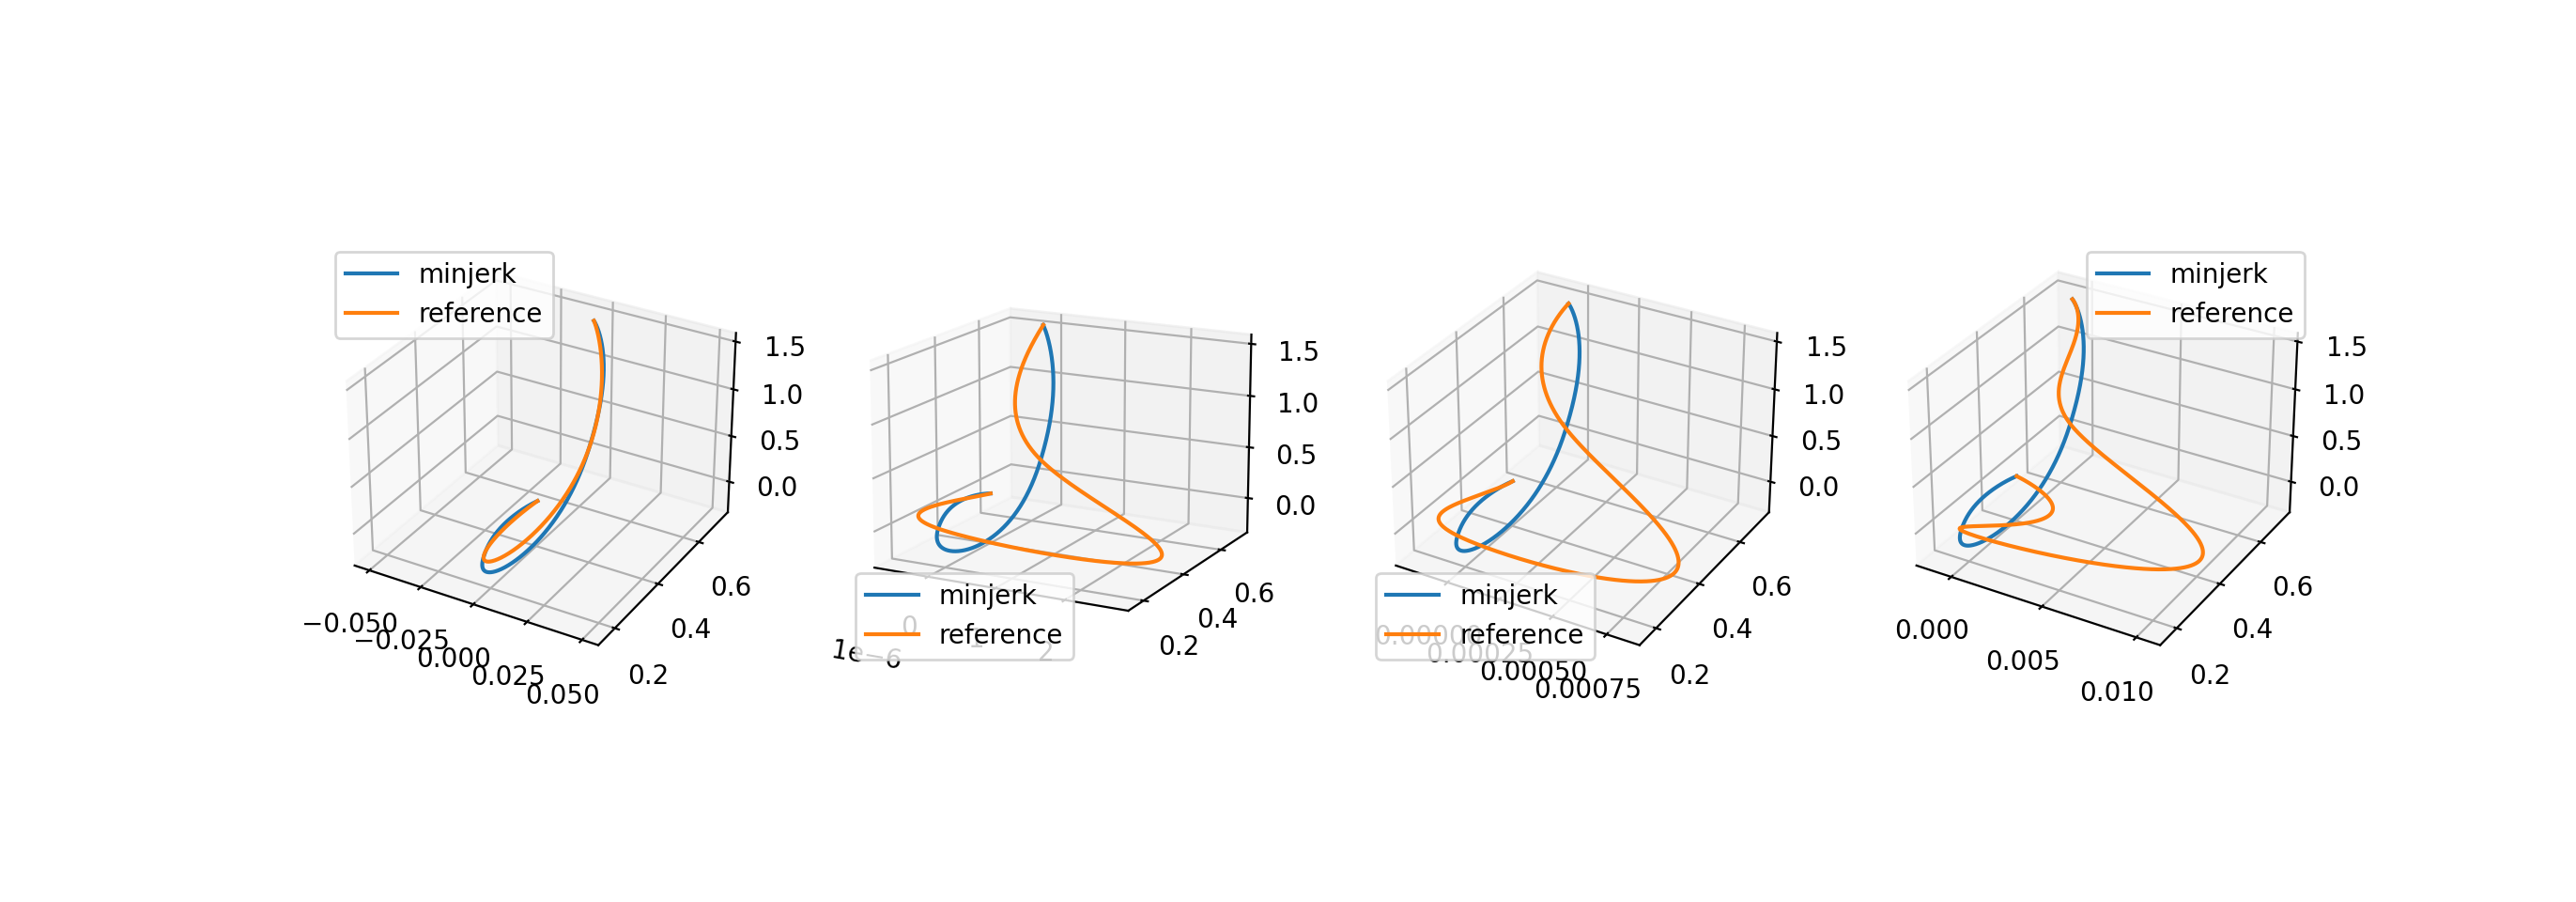

4


In [53]:
rhos = np.concatenate([[0], np.logspace(-3, 2, 3)])
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.35))

# =============
# First subplot
# =============
print(len(rhos))

for i, rho in enumerate(rhos):
    nn_coeff = nonlinear.generate(torch.tensor(waypt.T), ts, order, Tref, 10, rho, icnnvalue, torch.tensor(coeffs),
                   num_iter=100, lr=0.01)
    t, origx = nonlinear.coeff2traj(coeffs, ts, 1000)
    t, nnx = nonlinear.coeff2traj(nn_coeff, ts, 1000)
    # t, solx, = nonlinear.coeff2traj(sol_coeffs, ts, 1000)
    # set up the axes for the first plot
    ax = fig.add_subplot(1, len(rhos), i+1, projection='3d')
    # ax = plt.gca(projection='3d')
    # plt.subplot(1, len(rhos), i+1)
    ax.plot3D(origx[0], origx[1], origx[2], label='minjerk')
    ax.plot3D(nnx[0], nnx[1], nnx[2], label='reference')
    # ax.set_xlim(0, 0.8)
    # ax.set_ylim(0, 1)
    # ax.set_zlim(0, 0.4)
    ax.legend()

In [28]:
%matplotlib notebook

<IPython.core.display.Javascript object>


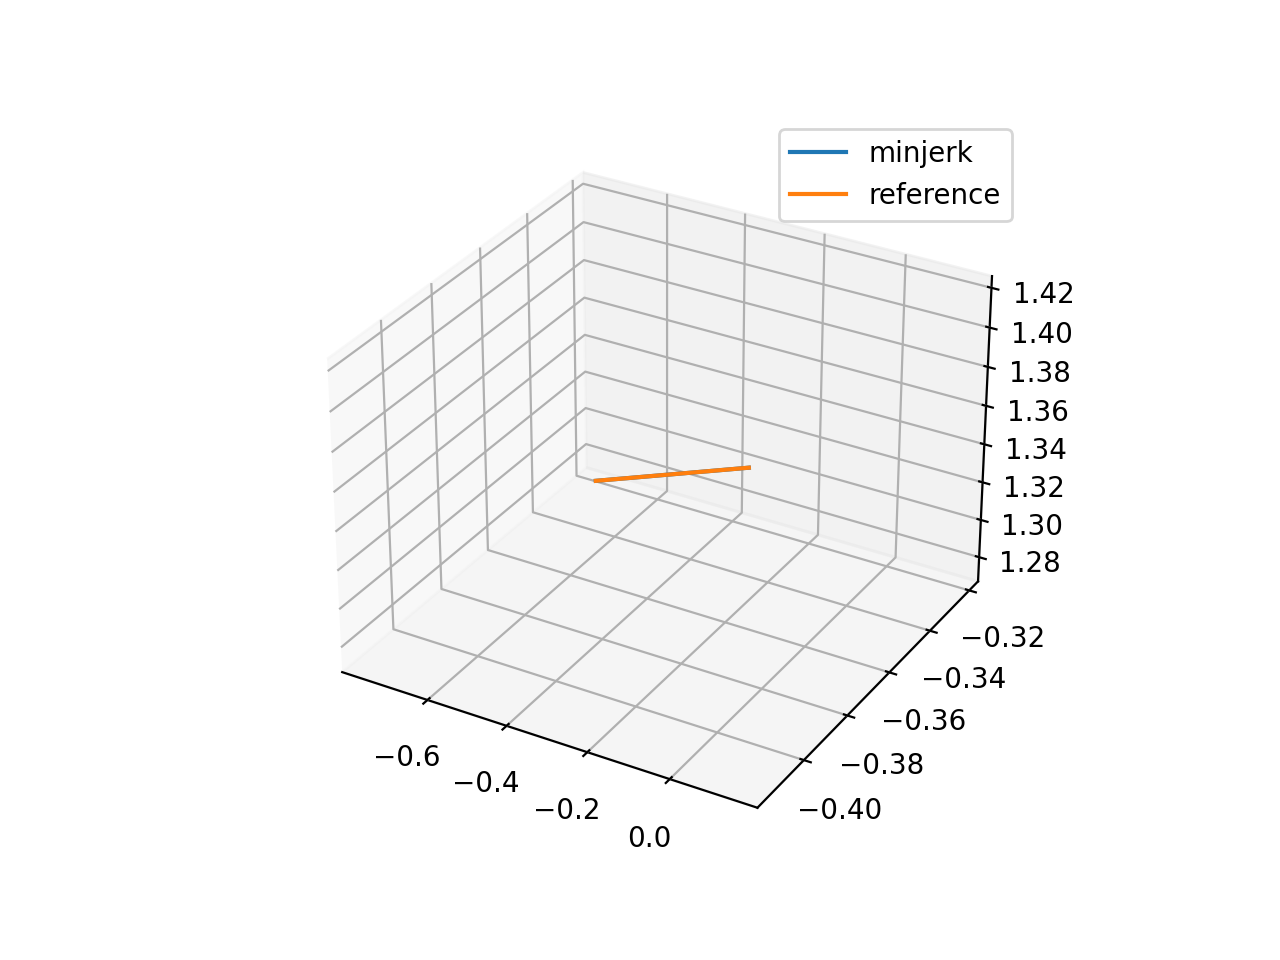

/tmp/ipykernel_4317/3637999067.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection='3d')


In [40]:
# 3d plot of the trajectory
ax = plt.gca(projection='3d')
ax.plot3D(origx[0], origx[1], origx[2], label='minjerk')
ax.plot3D(nnx[0], nnx[1], nnx[2], label='reference')
ax.legend()

In [61]:
# Generate a waypoints and the min-jerk trajectory
segments = 3
p = 10
waypoints = np.random.randn(p, segments+1)
waypoints[:, 0] = 0
waypoints[:, -1] = 0
print(waypoints)
ts = np.linspace(0,1,segments+1) * 3
print(ts)
#Pstar, Kstar = trackingenv.solve(Tref)
_, minjerk_coeffs = quadratic.generate(waypoints.T, ts, order, Tref, p, None, 0)

[[ 0.          0.33711441 -0.54356473  0.        ]
 [ 0.         -0.20752546  0.78348405  0.        ]
 [ 0.          1.02074454  1.13916138  0.        ]
 [ 0.         -0.43598189  1.06423703  0.        ]
 [ 0.          0.16940054 -0.9558009   0.        ]
 [ 0.          0.51878084  0.40352305  0.        ]
 [ 0.          0.70834408 -1.71561005  0.        ]
 [ 0.          0.04183925 -0.72669372  0.        ]
 [ 0.          0.06907345  1.8999669   0.        ]
 [ 0.          0.57077622 -1.32992055  0.        ]]
[0. 1. 2. 3.]


In [68]:
print(waypoints.shape)
print(minjerk_coeffs.shape)

(10, 4)
(10, 3, 7)


In [ ]:
p = 250
q = 100
T = 
num_trajs = 1000
gamma = 0.99

In [ ]:
lqrenv = linearenv.random_vanilla_env(p, q, QRratio=10, Anorm=1.0)
dataset = trajdata.TrajDataset(xtraj, utraj, rtraj, xtraj_)

## Testing optimization for inference using GPU

In [127]:
import torch_tensorrt

...

trt_ts_module = torch_tensorrt.compile(torch_script_module,
    inputs = [example_tensor, # Provide example tensor for input shape or...
        torch_tensorrt.Input( # Specify input object with shape and dtype
            min_shape=[1, 3, 224, 224],
            opt_shape=[1, 3, 512, 512],
            max_shape=[1, 3, 1024, 1024],
            # For static size shape=[1, 3, 224, 224]
            dtype=torch.half) # Datatype of input tensor. Allowed options torch.(float|half|int8|int32|bool)
    ],
    enabled_precisions = {torch.half}, # Run with FP16
)

result = trt_ts_module(input_data) # run inference
torch.jit.save(trt_ts_module, "trt_torchscript_module.ts") # save the TRT embedded Torchscript

ModuleNotFoundError: No module named 'torch_tensorrt'